# Workflow für die Visualisierung von Anomalien mit Pandas und Plotly

Prinzipieller Ablauf:

1. Einlesen der Daten als Dataframe
2. Festlegen, wo Anomalien vorliegen
3. Dataframe nach Datum und Anomalievorkommen gruppiert durchlaufen
4. Traces erstellen, Markerfarbe hängt von Anomalievorkommen ab 
5. JSON-Objekt mit den Traces erstellen
6. Das JSON-Objekt wird noch vom Backend/Server-seitig verarbeitet und so formatiert, dass Plotly.js es lesen kann
7. Formatiertes JSON an Plotly geben

## Einlesen der Daten

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [38]:
df = pd.read_excel("generatedData.xlsx", header=0)

In [39]:
df.head()

date  value
0 2020-01-01    196
1 2020-01-02   1646
2 2020-01-03     22
3 2020-01-06     70
4 2020-01-07    230

Der fiktive Beispieldatensatz beinhaltet Transaktionsdaten, die in Stapeln abgearbeitet werden und enthält zwei Spalten: Das Startdatum der Transaktion und die Anzahl der Elemente im Stapel. Eine Anomalie entspricht einer zu dem Zeitpunkt unerwartet hohen oder niedrigen Anzahl an Elementen. Die Transaktion könnte z.B. zum falschen Zeitpunkt gestartet worden sein oder nicht alle Elemente verarbeitet haben.

## Anomalieerkennung
Die Anomalieerkennung kann auf verschiedene Weisen geschehen. Beispielsweise könnte regelbasiert entschieden werden, ein Experte Anomalien markieren oder ein Neuronales Netz diese Entscheidung fällen. 

Eine einfache Regel wäre: Alle Werte, die außerhalb einer 2*$\sigma$ Umgebung rund um den Erwartungswert $\mu$ liegen, werden als Anomalien bezeichnet. Dabei könnte nochmal aufgeteilt werden zwischen einer leichten und einer kritischen Anomalie. Kritische Anomalien liegen außerhalb einer 3*$\sigma$ Umgebung. Diese Regel wird häufig verwendet, wenn die Daten normalverteilt sind. Dies ist hier nicht der Fall, wie untenstehendes Histogramm zeigt. 

Daher wird ein anderes Regelwerk verwendet, das nicht weiter berücksichtigt werden muss, da es individuell auf die Daten angepasst ist. Es bezieht aber nicht nur die Anzahl der Elemente in die Entscheidung ein, sondern auch das Startdatum. Für eine solche Anomalieerkennung ist es selbstverständlich notwendig, die Regeln für den jeweiligen Datensatz abzuleiten. In diesem Fall wurden die Daten extra nach den festgelegten Regeln generiert und Anomalien eingefügt. Dieser Prozess kann in Datengenerierung.ipynb nachvollzogen werden.

[]

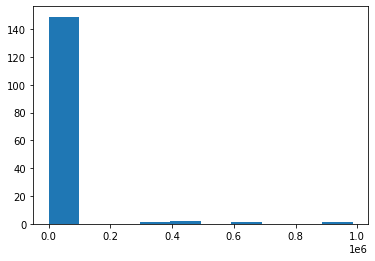

In [40]:
plt.hist(df.value)
plt.plot()

In [41]:
from anomalyDetection import detectAnomalies

df = detectAnomalies(df)

Danach hat der Dataframe eine zusätzliche Spalte: "anomalyState". Dieser Zustand kann die Werte 0 (Ok), 1 (Auffäligkeit / "leichte" Anomalie) und 2 (Vermuteter Fehler / "kritische" Anomalie) annehmen.

In [42]:
df.head()

date  value anomalyState
0 2020-01-01    196            0
1 2020-01-02   1646            0
2 2020-01-03     22            0
3 2020-01-06     70            0
4 2020-01-07    230            0

In [43]:
df["anomalyState"].value_counts()

0    148
1      4
2      2
Name: anomalyState, dtype: int64

In den Daten sind 144 Transaktionen normal gelaufen, bei 2 wird ein Fehler vermutet und 4 sind auffällig und sollten geprüft werden.

Für die Visualisierung mit Plotly legen wir aufgrund des anomalyState eine Farbe fest, indem wir ein Mapping vornehmen.

In [44]:
red = "#cc0000"
orange= "#e67300"
green = "#009933" 

anomalyToColorMap = {0: green, 1: orange, 2: red}

In [45]:
df["color"] = df.anomalyState.map(anomalyToColorMap)

In [46]:
df.tail()

date  value anomalyState    color
149 2020-07-28     48            0  #009933
150 2020-07-29     46            0  #009933
151 2020-07-30    219            0  #009933
152 2020-07-31     94            0  #009933
153 2020-08-03    501            0  #009933

## Erstellen der Traces
Die Traces werden in diesem Beispiel auf Monatsebene erzeugt, d.h. für jeden Monat wird eigentlich ein Trace erzeugt - somit könnte man in der späteren Plotly-Visualisierung jeden Monat einzeln an-/abwählen und so seine Sichtbarkeit toggeln. Dieser trace wird allerdings noch nach den jeweiligen anomalyStates aufgespalten. Der User kann dann beispielsweise ausschließlich die Anomalien der einzelnen Monate betrachten. Für andere Genauigkeitsebenen, z.B. Tag oder Jahr ist das Prinzip gleich.

Zunächst legen wir eine zusätzliche Spalte an, die den Monat enthält, der aus dem Startdatum extrahiert wird. Dabei wird der Monatszahl die Jahreszahl vorangestellt. Mai 2020 ist dann beispielsweise "2020-05"

In [47]:
df["month"] = df.date.dt.strftime("%Y-%m")

Jetzt erzeugen wir die Traces und verwenden dafür die untenstehenden Funktionen. Die Timetraces werden dann vom Backend verarbeitet.

In [48]:
def makeSerializable(obj):
    if type(obj) == pd.core.series.Series:
        return obj.to_numpy().tolist()
    elif type(obj) == np.ndarray:
        return obj.tolist()
    else:
        return obj

def appendTrace(traces, x, y, name, colors=None, visible=True):
    traceObj = {
        "x": x,
        "y": y,
        "type": "bar",
        "name": name,
        "visible": visible,
        "hoverinfo": "x+y+text",
        }
    if colors != None:
      traceObj["marker"] = {
        "color": colors 
        }

    traces.append(traceObj)

def appendTimetraces(traces, timeValue, timetraces):
    traceObj = {
        "time": timeValue,
        "timetraces": timetraces
        }
       
    traces.append(traceObj)

Der Name des Traces wird in der Legende angezeigt. Er besteht aus dem Monat ("2020-05") an den wir in Abhängigkeit der Farbe - und somit des anomalyStates - ein Suffix anhängen, damit in der Legende leichter zwischen Normal und Anomalie unterschieden werden kann.

In [49]:
traces = []
accuracy = "month"
for acc, df_groupedBy_Accuracy in df.groupby(accuracy, sort=True):
    timetraces = []
    for color, df_groupedBy_Color in df_groupedBy_Accuracy.groupby("color"):
        colorsList = df_groupedBy_Color.color.to_numpy().tolist()
        nameSuffix = "Ok"
        if color == red:
            nameSuffix = "Fehler vermutet"
        elif color == orange:
            nameSuffix = "Beobachten"
        y_data_verarbeitet = makeSerializable(df_groupedBy_Color.value)
        x_data = makeSerializable(df_groupedBy_Color.date.dt.strftime("%Y-%m-%d"))
        appendTrace(timetraces, x=x_data, y=y_data_verarbeitet, colors=colorsList, name='Elemente in der Transaktion (%s) - %s' % (acc, nameSuffix), visible=True )
    appendTimetraces(traces, acc, timetraces)

Ein Trace sieht dann beispielsweise so aus:

In [50]:
traces[0]

{'time': '2020-01',
 'timetraces': [{'x': ['2020-01-01',
    '2020-01-02',
    '2020-01-03',
    '2020-01-06',
    '2020-01-07',
    '2020-01-08',
    '2020-01-09',
    '2020-01-10',
    '2020-01-13',
    '2020-01-14',
    '2020-01-15',
    '2020-01-16',
    '2020-01-17',
    '2020-01-20',
    '2020-01-21',
    '2020-01-22',
    '2020-01-23',
    '2020-01-24',
    '2020-01-27',
    '2020-01-28',
    '2020-01-29',
    '2020-01-30',
    '2020-01-31'],
   'y': [196,
    1646,
    22,
    70,
    230,
    8,
    129,
    52,
    140,
    138,
    121,
    130,
    88,
    57,
    228,
    216,
    326297,
    136,
    189,
    6863,
    131,
    181,
    235],
   'type': 'bar',
   'name': 'Elemente in der Transaktion (2020-01) - Ok',
   'visible': True,
   'hoverinfo': 'x+y+text',
   'marker': {'color': ['#009933',
     '#009933',
     '#009933',
     '#009933',
     '#009933',
     '#009933',
     '#009933',
     '#009933',
     '#009933',
     '#009933',
     '#009933',
     '#009933',
 

Um den Graphen ein bisschen schöner zu gestalten, fügen wir zwei Buttons hinzu, mit denen die y-Skala zwischen linear und logarithmisch umgeschalten werden kann. Die default Einstellung ist logarithmisch, da man wegen den großen Unterschieden zwischen Maximal- und Minimalwerten sonst wenig erkennen kann:

In [51]:
chartTitle = "Elemente in Transaktionen"
title = '%s - %s' % (chartTitle, '(logarithmisch)')
updatemenus = list([
    dict(active=0,
        type = "buttons",
        direction = "down",
        buttons=list([
            dict(label='log.',
                method='update',
                args=[{'visible': True},
                    {'title': '%s - %s' % (chartTitle, '(logarithmisch)'),
                        'yaxis': {'type': 'log'}}]),
            dict(label='linear',
                method='update',
                args=[{'visible': True},
                    {'title': '%s - %s' % (chartTitle, '(linear)'),
                        'yaxis': {'type': 'linear'}}])
            ]),
        )
    ])

Außerdem nutzen wir die annotations-Möglichkeit, um die Bedeutung der Balkenfarbe anzuzeigen

In [52]:
annotations = [{
    "xref": 'paper',
    "yref": 'paper',
    "x": 1,
    "xanchor": 'right',
    "y": 1,
    "yanchor": 'bottom',
    "text": 'Bedeutung der Balkenfarbe <br>Grün: Ok <br>Orange: Beobachten <br>Rot: Fehler vermutet',
    "showarrow": False
}]

Insgesamt legen wir das layout wie folgt fest. Dabei können natürlich die verschiedenen Gestaltungsmöglichkeiten von Plotly beliebig genutzt werden.

In [53]:
layout = {
        "updatemenus": updatemenus,
        "annotations": annotations,
        "xaxis": {
        "showline": True,
        "showgrid": True,
        "showticklabels": True,
        "linewidth": 2,
        "ticks": "outside",
        "nticks": 31,
        "tickfont": {
            "family": "Arial",
            "size": 12,
        }
        },
        "yaxis": {
        "showgrid": True,
        "zeroline": True,
        "showline": True,
        "showticklabels": True,
        "type": "log"
        },
        "autosize": True,
        "margin": {
        "autoexpand": True,
        "l": 100,
        "r": 20,
        "t": 110,
        },
        "showlegend": True,
        "title": title
    }

Die einzelnen Komponenten fügen wir alle in ein JSON-Objekt zusammen. Dieses wird an das Backend geschickt, dafür setzen wir im Objekt noch ein paar Flags.

In [54]:
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d.%m.%Y (%H:%M)")
timeseries = True
multiple = True
chartData = {
    "title": title,
    "traces": traces,   
    "layout": layout,
    "updateTime" : timestampStr,
    "timeseries" : timeseries,
    "accuracy" :  accuracy,
    "multiple" : multiple,
}

## Änderungen im Backend
Die Änderungen im Backend sollen nur kurz beschrieben werden. Diese hängen von der jeweiligen Projektarchitektur ab. <br> Das Python-Skript, das im Wesentlichen die Schritte des Notebooks durchführt, wird aufgerufen. Das Ergebnis des Skriptes ist ein JSON Objekt. Dieses wird stückweise in einer Datenbank gespeichert und vom Backend in korrekter Form zusammengefügt an das Frontend geschickt. Dort generiert Plotly daraus den Plot.

Im Frontend wird die Javascript-Version von Plotly (Plotly.js) verwendet. Diese Bibliothek bietet den Aufruf

    Plotly.newPlot(graphDiv, data, layout, config)
    (https://plotly.com/javascript/plotlyjs-function-reference/)

an.

Diesen nutzen wir, um einen Plot zu erzeugen. Das graphDiv ist das DOM-Element, in dem das SVG gezeichnet werden soll. data sind unsere traces, layout das oben definierte Layout objekt und über config lassen sich beispielsweise Zoom- und Scrollverhalten anpassen. Hier genügen uns aber die default-konfigurationen.

Der erzeugte Plot sieht so aus:

![Plot](./img/ScreenshotPlot.PNG)


Man sieht, dass man über die Traces in der Legende die verschiedenen anomalyStates der einzelnen Monate beliebig toggeln kann. Außerdem ist offensichtlich, dass die Anomalieerkennung nicht ausschließlich anhand der Elementeanzahl stattgefunden hat, sondern die erwartete mit der aufgetreteten Elementeanzahl verglichen wurde.
<br>
Wenn man sich die Datengenerierung ansieht, wundert man sich vielleicht, warum mehr Balken orange sind als erwartet. Das liegt daran, dass bei der zufälligen Erzeugung der Daten, an denen z.B. die L1-Klasse auftritt, auch Tage an Wochenenden entstanden sind. Diese sind in den Daten allerdings nicht vorhanden! Der L1 sollte im März nach laut der Generierungsdatei zum Beispiel am 01.03.2020 passieren. Da dieser Tag aber gar nicht existiert, fehlt im März der L1 und die beiden "Kandidaten-Tage" 02.03.2020 und 03.03.2020 sind korrekterweise orange.  
